In [1]:

# Importing Coup Env
from coup_env.coup_env import CoupEnv
from coup_env.classes.actions import Actions

import yaml
# Utility Imports
import pandas as pd
import numpy as np
import os



In [2]:
def translate_dict(data_dict, _card_combination_map, card_name_map, NEXT_ACTION_TYPE_MAP, ACTION_SPACE_MAP):
    """
    Translates values in a dictionary based on specified mapping dictionaries.

    Args:
    - data_dict (dict): The dictionary containing the data to be translated.
    - _card_combination_map (dict): A dictionary to map `agent_cards` values.
    - card_name_map (dict): A dictionary to map `revealed` and `current_claimed_card` values.
    - NEXT_ACTION_TYPE_MAP (dict): A dictionary to map `next_action_type` values.

    Returns:
    - dict: The translated dictionary with updated values.
    """
    # Translate `agent_cards`
    data_dict['agent_cards'] = _card_combination_map.get(data_dict['agent_cards'], 'Unknown')
    data_dict['agent_cards'] = [card_name_map.get(card) for card in data_dict['agent_cards']]

    # Translate `revealed` keys
    data_dict['revealed'] = {card_name_map.get(int(k)): v for k, v in data_dict['revealed'].items()}
    data_dict['claims'] = {k: [card_name_map.get(i) for i,card in enumerate(v) if card==1] for k,v in data_dict['claims'].items()}

    # Translate `current_claimed_card`
    data_dict['current_claimed_action'] = ACTION_SPACE_MAP.get(data_dict['current_claimed_action'], 'ERROR')

    # Translate `next_action_type`
    data_dict['next_action_type'] = NEXT_ACTION_TYPE_MAP.get(data_dict['next_action_type'], 'ERROR')
    return data_dict

def translate_action_column(df, action_map):
    df['action'] = df['action'].apply(lambda x: action_map.get(x, 'Unknown'))
    return df

def get_maps():
    coup_env = CoupEnv(2)
    # coup_env._action_space_map
    ACTION_SPACE_MAP = {v: k for k, v in coup_env._action_space_map.items()}
    CARD_NAME_MAP = {v: k for k, v in coup_env._card_name_map.items()}
    NEXT_ACTION_TYPE_MAP = {v: k for k, v in coup_env.NEXT_ACTION_TYPE_MAP.items()}
    CARD_COMBINATION_MAP = coup_env._card_combination_map
    
    return ACTION_SPACE_MAP, CARD_NAME_MAP, NEXT_ACTION_TYPE_MAP, CARD_COMBINATION_MAP

def CARD_ACTION_MAP():
    ACTIONS = Actions()
    return ACTIONS.CARDS_ACTIONS_MAP

def path_to_actions():
    return "/home/aadrian/Documents/RL_projects/RL_COUP/coup/metrics/actions/play_game_actions.jsonl"

import yaml 
def lesson():
    with open("/home/aadrian/Documents/RL_projects/RL_COUP/curriculums/lesson1.yaml") as file:
        LESSON = yaml.safe_load(file)
    return LESSON

def load_actions(path_to_actions):
    df = pd.read_json(path_to_actions,   lines=True)
    ACTION_SPACE_MAP, CARD_NAME_MAP, NEXT_ACTION_TYPE_MAP, CARD_COMBINATION_MAP = get_maps()
    n_actions = len(df['action'].unique())
    
    df = translate_action_column(df, action_map=ACTION_SPACE_MAP)
    assert n_actions == len(df['action'].unique())
    
    df['state'] = df['state'].apply(lambda x: translate_dict(x, CARD_COMBINATION_MAP, CARD_NAME_MAP, NEXT_ACTION_TYPE_MAP, ACTION_SPACE_MAP))
    df['next_state'] = df['next_state'].apply(lambda x: translate_dict(x, CARD_COMBINATION_MAP, CARD_NAME_MAP, NEXT_ACTION_TYPE_MAP, ACTION_SPACE_MAP))
    
    # unpack states
    state = pd.DataFrame(df['state'].apply(pd.Series))
    state.columns = [f"ORIGONAL_{col}" for col in state.columns]
    next_state = pd.DataFrame(df['next_state'].apply(pd.Series))
    next_state.columns = [f"STEPPED_{col}" for col in next_state.columns]

    
    df = pd.concat([df, state, next_state], axis = 1)

    assert 'action_mask' in df.keys()
    df['action_mask'] = df.apply(lambda x: translate_action_mask(x, ACTION_SPACE_MAP), axis=1)

    return df

def translate_action_mask(row, ACTION_SPACE_MAP):
    # Extract the original action mask from the row
    action_mask = row['action_mask']
    # Ensure the action_mask is a list or array
    if not isinstance(action_mask, (list, tuple)):  
        return None  # or handle the error as needed
    # Translate action mask using ACTION_SPACE_MAP
    translated_mask = [ACTION_SPACE_MAP[index] for index, action_bool in enumerate(action_mask) if action_bool == 1]
    return translated_mask  # Returning a list (not modifying row directly)



In [3]:
actions = load_actions(path_to_actions())

Action Map
{'assassinate_0': 0, 'assassinate_1': 1, 'challenge': 2, 'coup_0': 3, 'coup_1': 4, 'exchange': 5, 'exe': 6, 'foreign_aid': 7, 'income': 8, 'none': 9, 'pass': 10, 'steal_0': 11, 'steal_1': 12, 'tax': 13}


# Most common Action made by Agent

In [4]:
actions = actions[actions['ORIGONAL_current_acting_player'] == 0]
actions.head()

,game_id,action,action_mask,reward,cum_reward,termination,all_cards,state,next_state,ORIGONAL_agent_cards,...,ORIGONAL_current_acting_player,STEPPED_agent_cards,STEPPED_claims,STEPPED_n_cards,STEPPED_money,STEPPED_revealed,STEPPED_current_base_player,STEPPED_current_claimed_action,STEPPED_next_action_type,STEPPED_current_acting_player
0,0,foreign_aid,"[exchange, foreign_aid, income, steal_1, tax]",0.0,0.0,False,"{'0': ['contessa', 'captain'], '1': ['ambassad...","{'agent_cards': ['contessa', 'captain'], 'clai...","{'agent_cards': ['ambassador', 'duke'], 'claim...","[contessa, captain]",...,0,"[ambassador, duke]","{'0': [], '1': []}","{'0': 2, '1': 2}","{'0': 2, '1': 2}","{'assassin': 0, 'captain': 0, 'duke': 0, 'cont...",0,foreign_aid,challenge_action,1
2,0,exe,[exe],0.2,0.2,False,"{'0': ['contessa', 'captain'], '1': ['ambassad...","{'agent_cards': ['contessa', 'captain'], 'clai...","{'agent_cards': ['ambassador', 'duke'], 'claim...","[contessa, captain]",...,0,"[ambassador, duke]","{'0': [], '1': []}","{'0': 2, '1': 2}","{'0': 4, '1': 2}","{'assassin': 0, 'captain': 0, 'duke': 0, 'cont...",1,none,claim_base_action,1
4,0,pass,[pass],0.0,0.2,False,"{'0': ['contessa', 'captain'], '1': ['ambassad...","{'agent_cards': ['contessa', 'captain'], 'clai...","{'agent_cards': ['ambassador', 'duke'], 'claim...","[contessa, captain]",...,0,"[ambassador, duke]","{'0': [], '1': []}","{'0': 2, '1': 2}","{'0': 4, '1': 2}","{'assassin': 0, 'captain': 0, 'duke': 0, 'cont...",1,income,exe_action,1
6,0,assassinate_1,"[assassinate_1, exchange, foreign_aid, income,...",-0.3,-0.1,False,"{'0': ['contessa', 'captain'], '1': ['ambassad...","{'agent_cards': ['contessa', 'captain'], 'clai...","{'agent_cards': ['ambassador', 'duke'], 'claim...","[contessa, captain]",...,0,"[ambassador, duke]","{'0': ['ambassador'], '1': []}","{'0': 2, '1': 2}","{'0': 1, '1': 3}","{'assassin': 0, 'captain': 0, 'duke': 0, 'cont...",0,assassinate_1,challenge_action,1
8,0,exe,[exe],0.5,0.4,False,"{'0': ['contessa', 'captain'], '1': ['duke']}","{'agent_cards': ['contessa', 'captain'], 'clai...","{'agent_cards': ['unknown', 'duke'], 'claims':...","[contessa, captain]",...,0,"[unknown, duke]","{'0': ['ambassador'], '1': []}","{'0': 2, '1': 1}","{'0': 1, '1': 3}","{'assassin': 0, 'captain': 0, 'duke': 0, 'cont...",1,none,claim_base_action,1


In [ ]:
counts = actions.value_counts('action')
counts = counts.loc[['foreign_aid','challenge','assassinate_1','pass','exchange']]


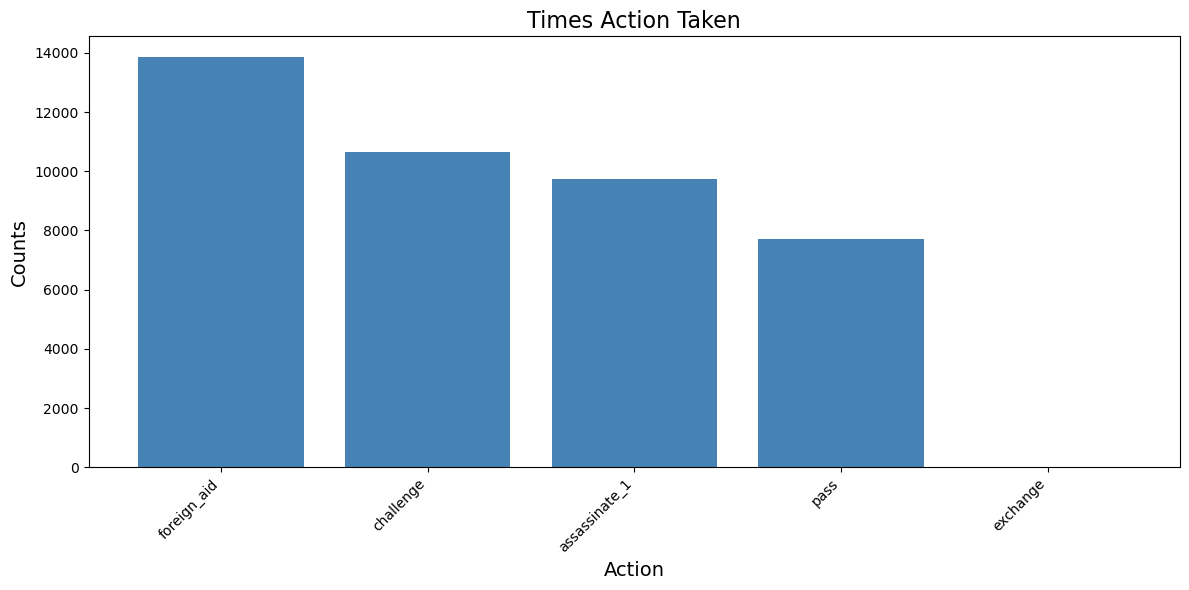

In [ ]:
import matplotlib.pyplot as plt

# Assuming counts is your Series with the data for the bar plot
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color='steelblue')

# Add title and labels
plt.title('Times Action Taken', fontsize=16)
plt.xlabel('Action', fontsize=14)
plt.ylabel('Counts', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()

plt.savefig('action_counts.png')
plt.show()

# Evaluating the Win rate of starting cards

In [5]:
actions = load_actions(path_to_actions())

Action Map
{'assassinate_0': 0, 'assassinate_1': 1, 'challenge': 2, 'coup_0': 3, 'coup_1': 4, 'exchange': 5, 'exe': 6, 'foreign_aid': 7, 'income': 8, 'none': 9, 'pass': 10, 'steal_0': 11, 'steal_1': 12, 'tax': 13}


In [30]:
starting_cards_wincount = {}
lo_winning_players = []
lo_starting_card1 = []
lo_starting_card2 = []
for game_id, game_df in actions.groupby("game_id"):
    winning_player = str(game_df.tail(1).loc[:, 'ORIGONAL_current_acting_player'].values[0])
    lo_winning_players.append(winning_player)

    starting_cards = tuple(game_df.head(1).loc[:, 'all_cards'].values[0][winning_player])

    starting_cards_wincount[starting_cards] = starting_cards_wincount.get(starting_cards, 0) + 1

    starting_cards = list(game_df.head(1).loc[:, 'all_cards'].values[0][winning_player])
    lo_starting_card1.append(starting_cards[0])
    lo_starting_card2.append(starting_cards[1])
    
df = pd.DataFrame([starting_cards_wincount])
df.to_csv("starting_cards_wincount.csv")

In [37]:
agent_won = pd.Series(lo_winning_players).replace({"0": 1, "1": 0})
stats_ds = pd.DataFrame({'agent_won': agent_won, 'starting_card1': lo_starting_card1, 'starting_card2': lo_starting_card2})

card_types = set(stats_ds['starting_card1']).union(set(stats_ds['starting_card2']))
for card in card_types:
    stats_ds[f'Has_{card}'] = stats_ds.apply(lambda row: int(card in [row['starting_card1'], row['starting_card2']]), axis=1)
# Drop the original columns
stats_ds= stats_ds.drop(columns=['starting_card1', 'starting_card2'])

stats_ds 


/tmp/ipykernel_4410/3332841078.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agent_won = pd.Series(lo_winning_players).replace({"0": 1, "1": 0})


,agent_won,Has_assassin,Has_ambassador,Has_captain,Has_duke,Has_contessa
0,1,0,0,1,0,1
1,1,0,1,0,0,1
2,1,0,1,0,0,1
3,1,1,0,1,0,0
4,1,0,0,1,1,0
...,...,...,...,...,...,...
9995,0,0,0,1,1,0
9996,1,1,0,0,0,1
9997,1,1,0,1,0,0
9998,1,0,0,1,1,0


In [86]:
card_combo_count  = stats_ds.groupby(by = ['Has_contessa', 'Has_assassin', 'Has_captain', 'Has_duke', "Has_ambassador"]).size().reset_index()
card_combo_count.columns = ['Has_contessa', 'Has_assassin', 'Has_captain', 'Has_duke', "Has_ambassador", 'occurances']
card_combo_count


win_count  = stats_ds[stats_ds.loc[:,'agent_won']==1].groupby(by = ['Has_contessa', 'Has_assassin', 'Has_captain', 'Has_duke', "Has_ambassador"]).size().reset_index()
win_count.columns = ['Has_contessa', 'Has_assassin', 'Has_captain', 'Has_duke', "Has_ambassador", 'wins']
win_count 

,Has_contessa,Has_assassin,Has_captain,Has_duke,Has_ambassador,wins
0,0,0,0,0,1,243
1,0,0,0,1,0,240
2,0,0,0,1,1,680
3,0,0,1,0,0,286
4,0,0,1,0,1,751
5,0,0,1,1,0,733
6,0,1,0,0,0,225
7,0,1,0,0,1,685
8,0,1,0,1,0,661
9,0,1,1,0,0,666


In [89]:
card_combo_count

,Has_contessa,Has_assassin,Has_captain,Has_duke,Has_ambassador,occurances
0,0,0,0,0,1,305
1,0,0,0,1,0,298
2,0,0,0,1,1,887
3,0,0,1,0,0,328
4,0,0,1,0,1,945
5,0,0,1,1,0,914
6,0,1,0,0,0,259
7,0,1,0,0,1,867
8,0,1,0,1,0,798
9,0,1,1,0,0,792


Has_contessa
Has_assassin
790
667
Has_contessa
Has_captain
889
724
Has_contessa
Has_duke
789
664
Has_contessa
Has_ambassador
876
747
Has_assassin
Has_contessa
790
667
Has_assassin
Has_captain
792
666
Has_assassin
Has_duke
798
661
Has_assassin
Has_ambassador
867
685
Has_captain
Has_contessa
889
724
Has_captain
Has_assassin
792
666
Has_captain
Has_duke
914
733
Has_captain
Has_ambassador
945
751
Has_duke
Has_contessa
789
664
Has_duke
Has_assassin
798
661
Has_duke
Has_captain
914
733
Has_duke
Has_ambassador
887
680
Has_ambassador
Has_contessa
876
747
Has_ambassador
Has_assassin
867
685
Has_ambassador
Has_captain
945
751
Has_ambassador
Has_duke
887
680


/tmp/ipykernel_4410/237310195.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25366403607666294' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[card1, card2] = win_count[win_count[card1] == 1]['wins'].values[0]/occurance
/tmp/ipykernel_4410/237310195.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.84' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[card1, card2] = win_rate
/tmp/ipykernel_4410/237310195.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.81' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_data.loc[card1, card2] = win_rate
/tmp/ipykernel_4410/2373

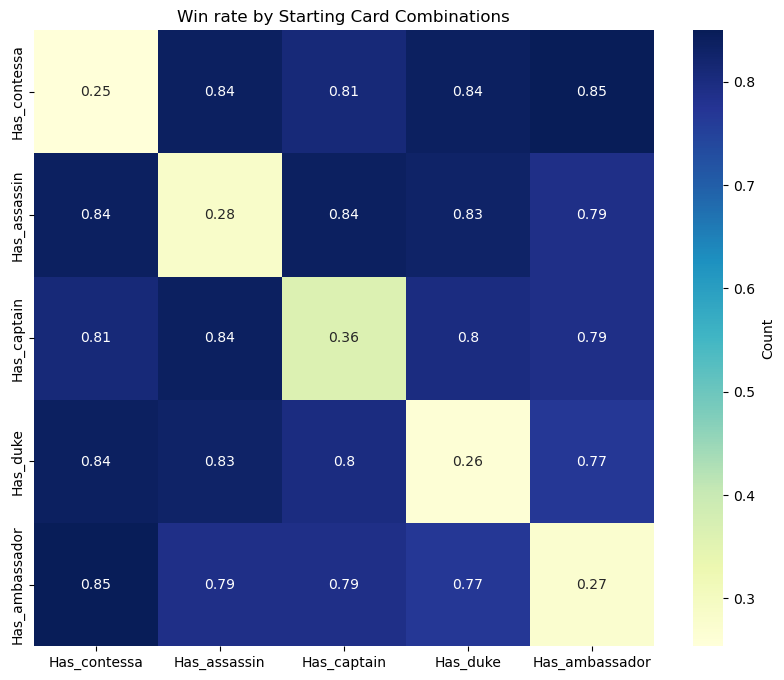

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming win_count is your DataFrame
# Example structure:
# | Has_contessa | Has_assassin | Has_captain | Has_duke | Has_ambassador | wins |
# |--------------|--------------|-------------|----------|----------------|------|
# | 0            | 0            | 0           | 0        | 1              | 305  |
# | 0            | 0            | 0           | 1        | 0              | 298  |
# | 0            | 0            | 0           | 1        | 1              | 887  |
# | 0            | 0            | 1           | 0        | 0              | 328  |
# | 0            | 0            | 1           | 0        | 1              | 945  |
# | 0            | 0            | 1           | 1        | 0              | 914  |
# | 0            | 1            | 0           | 0        | 0              | 259  |
# | 0            | 1            | 0           | 0        | 1              | 867  |
# | 0            | 1            | 0           | 1        | 0              | 798  |
# | 0            | 1            | 1           | 0        | 0              | 792  |
# | 1            | 0            | 0           | 0        | 0              | 263  |
# | 1            | 0            | 0           | 0        | 1              | 876  |
# | 1            | 0            | 0           | 1        | 0              | 789  |
# | 1            | 0            | 1           | 0        | 0              | 889  |

# Create a DataFrame with the counts of wins for each pair of card types
card_types = ['Has_contessa', 'Has_assassin', 'Has_captain', 'Has_duke', 'Has_ambassador']
heatmap_data = pd.DataFrame(index=card_types, columns=card_types, data=0)

for card1 in card_types:
    for card2 in card_types:
        if card1 != card2:
            occurance = card_combo_count[(card_combo_count[card1] == 1) & (card_combo_count[card2] == 1)]['occurances'].values[0]    
            print(card1)
            print(card2)
            print(occurance)
            print(win_count[(win_count[card1] == 1) & (win_count[card2] == 1)]['wins'].values[0])
            win_rate = np.round(win_count[(win_count[card1] == 1) & (win_count[card2] == 1)]['wins'].values[0]/occurance,2)
            heatmap_data.loc[card1, card2] = win_rate
        else:
            occurance = card_combo_count[(card_combo_count[card1] == 1)]['occurances'].values[0]    

            heatmap_data.loc[card1, card2] = win_count[win_count[card1] == 1]['wins'].values[0]/occurance

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Win rate by Starting Card Combinations')
# plt.xlabel('Card Types')
# plt.ylabel('Card Types')
plt.show()

In [96]:
card_combo_count

,Has_contessa,Has_assassin,Has_captain,Has_duke,Has_ambassador,occurances
0,0,0,0,0,1,305
1,0,0,0,1,0,298
2,0,0,0,1,1,887
3,0,0,1,0,0,328
4,0,0,1,0,1,945
5,0,0,1,1,0,914
6,0,1,0,0,0,259
7,0,1,0,0,1,867
8,0,1,0,1,0,798
9,0,1,1,0,0,792


In [74]:
heatmap_data.sum().sum()

np.int64(18547)

In [55]:
heatmap_data

Has_ambassador                                      0      1
Has_contessa Has_assassin Has_captain Has_duke              
0            0            0           0           0.0  305.0
                                      1         298.0  887.0
                          1           0         328.0  945.0
                                      1         914.0    0.0
             1            0           0         259.0  867.0
                                      1         798.0    0.0
                          1           0         792.0    0.0
1            0            0           0         263.0  876.0
                                      1         789.0    0.0
                          1           0         889.0    0.0
             1            0           0         790.0    0.0

In [53]:
heatmap_data 

Has_ambassador                                      0      1
Has_contessa Has_assassin Has_captain Has_duke              
0            0            0           0           0.0  305.0
                                      1         298.0  887.0
                          1           0         328.0  945.0
                                      1         914.0    0.0
             1            0           0         259.0  867.0
                                      1         798.0    0.0
                          1           0         792.0    0.0
1            0            0           0         263.0  876.0
                                      1         789.0    0.0
                          1           0         889.0    0.0
             1            0           0         790.0    0.0

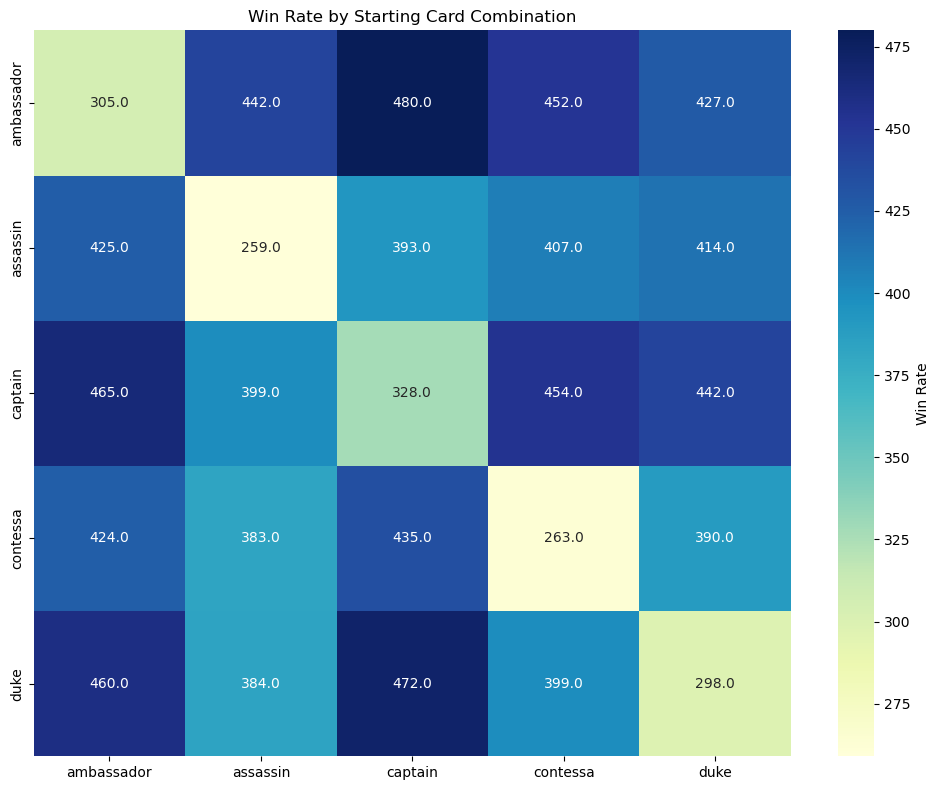

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame
# Convert the single row of the original DataFrame into a dictionary
data = df.iloc[0].to_dict()

data

# Create a new DataFrame from the dictionary
collapsed_df = pd.DataFrame.from_dict(data, orient='index').reset_index()

# Split the 'index' column into 'Column' and 'Row'
collapsed_df[['Column', 'Row']] = pd.DataFrame(collapsed_df['index'].tolist(), index=collapsed_df.index)

# Drop the original 'index' column and rename the remaining column to 'Value'
collapsed_df = collapsed_df.drop(columns=['index'])
collapsed_df.columns = ['Value', 'Column', 'Row']

# Pivot the DataFrame to get the desired format
heatmap_df = collapsed_df.pivot(index='Row', columns='Column', values='Value')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Win Rate'})
plt.title('Win Rate by Starting Card Combination')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig("heatmap_card_pair_win.png")
plt.show()


In [21]:
collapsed_df

,Value,Column,Row
0,454,contessa,captain
1,424,ambassador,contessa
2,452,contessa,ambassador
3,399,assassin,captain
4,472,captain,duke
5,442,assassin,ambassador
6,465,ambassador,captain
7,393,captain,assassin
8,390,duke,contessa
9,263,contessa,contessa


# Statistical model

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm

# Assuming heatmap_df is your DataFrame with the number of wins and trials
# Add a column for WinRate (wins divided by total trials)
# # Create binary features indicating the presence of each card type

agent_won = pd.Series(lo_winning_players).replace({"0": 1, "1": 0})
stats_ds = pd.DataFrame({'agent_won': agent_won, 'starting_card1': lo_starting_card1, 'starting_card2': lo_starting_card2})


card_types = set(stats_ds['starting_card1']).union(set(stats_ds['starting_card2']))
for card in card_types:
    stats_ds[f'Has_{card}'] = stats_ds.apply(lambda row: int(card in [row['starting_card1'], row['starting_card2']]), axis=1)
# Drop the original columns
stats_ds= stats_ds.drop(columns=['starting_card1', 'starting_card2'])

stats_ds = stats_ds.head(5)
stats_ds

/tmp/ipykernel_4410/1764307092.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agent_won = pd.Series(lo_winning_players).replace({"0": 1, "1": 0})


,agent_won,Has_assassin,Has_ambassador,Has_captain,Has_duke,Has_contessa
0,1,0,0,1,0,1
1,1,0,1,0,0,1
2,1,0,1,0,0,1
3,1,1,0,1,0,0
4,1,0,0,1,1,0


In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Assuming X and y are your provided DataFrames
# Example structure:
# X:
# | Has_assassin | Has_ambassador | Has_captain | Has_contessa | Has_duke |
# |--------------|----------------|-------------|--------------|----------|
# | 0            | 0              | 1           | 1            | 0        |
# | 0            | 1              | 0           | 1            | 0        |
# | 0            | 1              | 0           | 1            | 0        |
# | 1            | 0              | 1           | 0            | 0        |
# y:
# | Win |
# |-----|
# | 0   |
# | 0   |
# | 0   |
# | 0   |
# | 0   |

# Split the data into features (X) and target (y)
X = stats_ds.drop(columns=['agent_won'])
y = stats_ds['agent_won']


# Ensure that the data types are correct
X = X.astype(int)
y = y.astype(int)

# Add a constant to the features (intercept term)
X = sm.add_constant(X)

# Fit the logistic regression model using statsmodels
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

# Predict on the training set
y_pred_proba = result.predict(X)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              agent_won   No. Observations:                    5
Model:                          Logit   Df Residuals:                        1
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                     inf
Time:                        14:11:54   Log-Likelihood:            -4.3610e-13
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.3061   1.85e+14   8.83e-14      1.000   -3.62e+14    3.62e+14
Has_assassin       4.5123   1.78e+14   2.53e-14      

/home/aadrian/miniforge3/envs/pymc_env/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aadrian/miniforge3/envs/pymc_env/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aadrian/miniforge3/envs/pymc_env/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aadrian/miniforge3/envs/pymc_env/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

In [ ]:
X.values.dtype

dtype('int64')

In [ ]:
X2.values.dtype

dtype('int64')

In [ ]:
y.values.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], shape=(10000, 1))

In [ ]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], shape=(10000, 1))

Initializing NUTS using jitter+adapt_diag...


X DataFrame:
    Has_assassin  Has_ambassador  Has_captain  Has_contessa  Has_duke
0              0               0            1             1         0
1              0               1            0             1         0
2              0               1            0             1         0
3              1               0            1             0         0
4              0               0            1             0         1
..           ...             ...          ...           ...       ...
95             0               1            0             0         1
96             0               0            0             1         0
97             0               0            1             1         0
98             1               0            1             0         0
99             1               0            1             0         0

[100 rows x 5 columns]

Y DataFrame:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Has_assassin, Has_ambassador, Has_captain, Has_contessa, Has_duke]


/home/aadrian/miniforge3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Has_assassin    0.670  0.857  -0.905    2.304      0.008    0.007   10854.0   
Has_ambassador -0.318  0.934  -2.023    1.493      0.010    0.009    9488.0   
Has_captain     0.314  0.931  -1.400    2.045      0.009    0.009    9827.0   
Has_contessa   -0.643  0.871  -2.227    1.075      0.008    0.008   10939.0   
Has_duke       -0.313  0.917  -1.985    1.435      0.008    0.009   12039.0   

                ess_tail  r_hat  
Has_assassin      7175.0    1.0  
Has_ambassador    5897.0    1.0  
Has_captain       6622.0    1.0  
Has_contessa      6672.0    1.0  
Has_duke          6936.0    1.0  


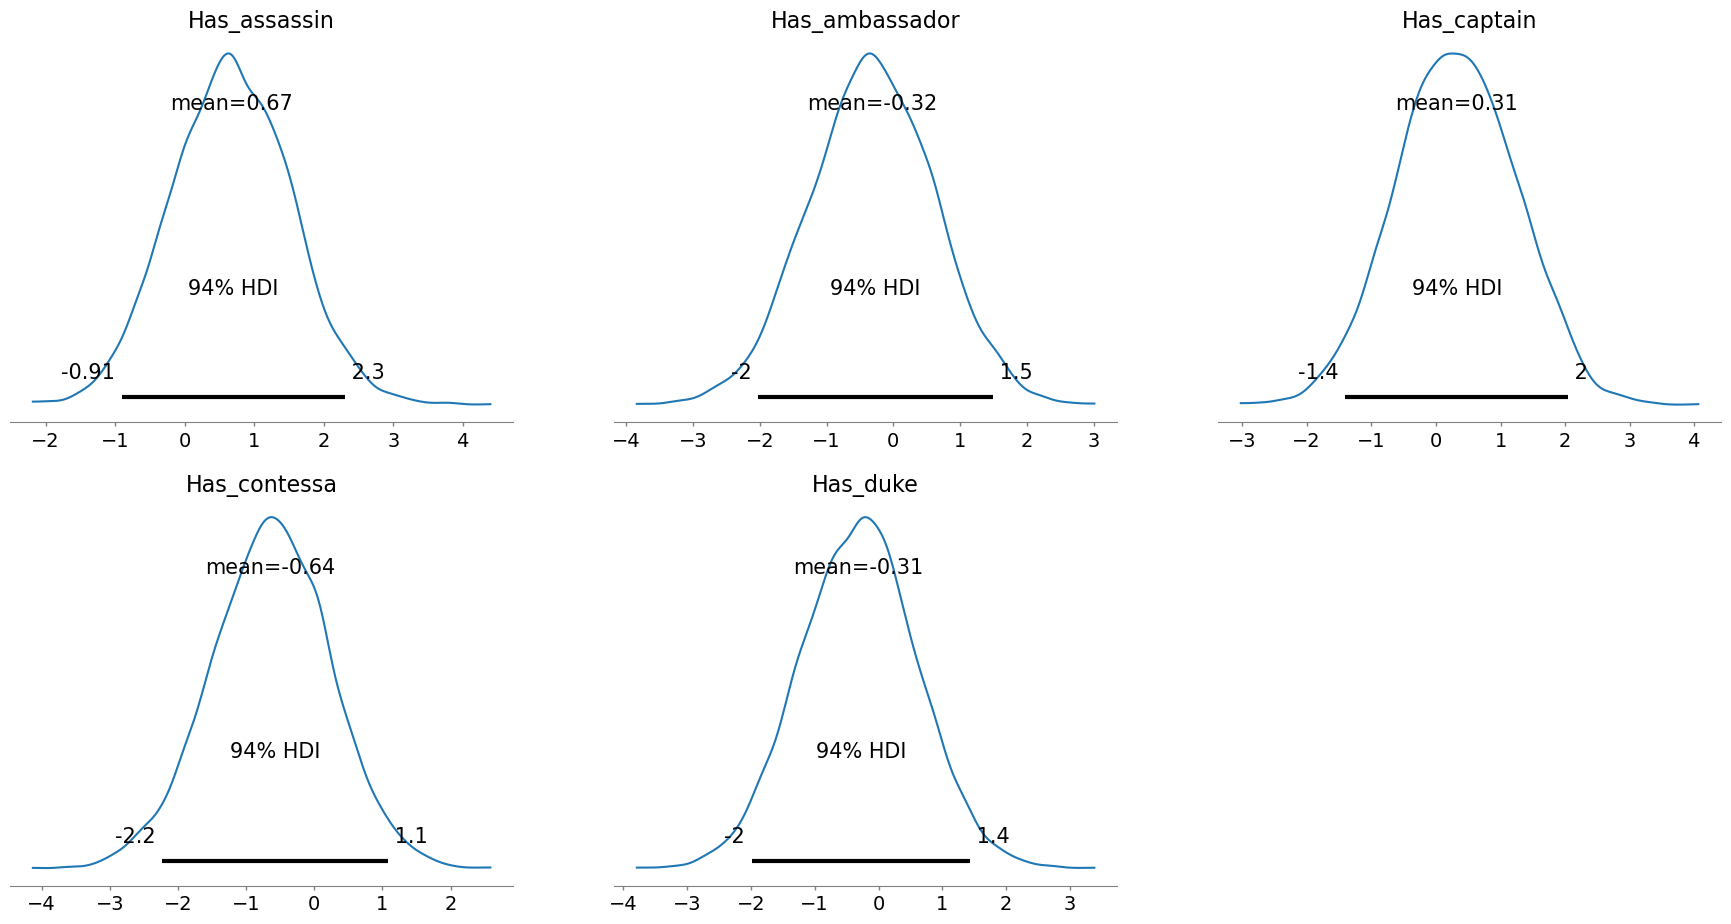

InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got np.int64(0) instead.

In [ ]:
# import pandas as pd
# import numpy as np
# import pymc as pm
# import arviz as az
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Example X DataFrame
X2 = pd.DataFrame({
    'Has_assassin': [1, 1, 0, 0],
    'Has_ambassador': [0, 0, 1, 0],
    'Has_captain': [1, 0, 0, 0],
    'Has_contessa': [0, 0, 1, 1],
    'Has_duke': [0, 0, 0, 1]
})

# Example y DataFrame
y2 = pd.DataFrame({
    'Win': [1, 1, 0, 0]
})

# # Ensure that the data types are correct
X = X.astype(int)
y = y.astype(int)

# Print the data to verify
print("X DataFrame:")
print(X)
print("\nY DataFrame:")
print(y)

# Print the data to verify
print("X DataFrame:")
print(X2)
print("\nY DataFrame:")
print(y2)


# Bayesian logistic regression model
with pm.Model() as model:
    # Priors for the coefficients
    priors = {col: pm.Normal(col, mu=0, sigma=1) for col in X.columns}
    
    # Linear combination of features
    linear_combination = sum(priors[col] * X2[col].values for col in X.columns)
    
    # Transform the linear combination to probability using the logistic (sigmoid) function
    p = pm.Deterministic('p', pm.math.sigmoid(linear_combination))
    
    # Logistic regression likelihood
    likelihood = pm.Bernoulli('likelihood', p=p, observed=y2['Win'].values)
    
    # Inference
    trace = pm.sample(2000, tune=1000, chains=4, cores=2, return_inferencedata=True)

# Summary of the trace
summary = az.summary(trace, var_names=list(X.columns))
print(summary)

# Plot the posterior distributions of the coefficients
az.plot_posterior(trace, var_names=list(X.columns))
plt.show()

# Predict on the training set
posterior_p = trace.posterior['p'].mean(dim=['chain', 'draw']).values
y_pred_proba = posterior_p.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred_proba)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

In [ ]:
p

p

In [ ]:
linear_combination

Add.0